In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import error_inject_layer
import error_inject_optimizer
from tensorflow.python.util import deprecation
import tensorflow_datasets as tfds
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels


In [3]:
train_dataset_fp = "/home/derek/.keras/datasets/iris_training.csv"
test_fp = "/home/derek/.keras/datasets/iris_test.csv"

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [4]:
batch_size = 32
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [5]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

In [6]:
print("DATASET INFO:")
print(type(train_dataset))
print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

DATASET INFO:
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [7]:
test_dataset = test_dataset.map(pack_features_vector)
train_dataset = train_dataset.map(pack_features_vector)

In [8]:
print("CHANGE TO NUMPY")
train_numpy = tfds.as_numpy(train_dataset)
test_numpy = tfds.as_numpy(test_dataset)
# print(train_numpy)
train_feature_array = np.empty((0,4), dtype=np.float32)
train_label_array = np.empty((0,), dtype=np.int32)
for ex in train_numpy:
  train_feature_array = np.concatenate((train_feature_array,ex[0]), axis=0)
  train_label_array = np.append(train_label_array, ex[1])

test_feature_array = np.empty((0,4), dtype=np.float32)
test_label_array = np.empty((0,), dtype=np.int32)
for ex in test_numpy:
  test_feature_array = np.concatenate((test_feature_array,ex[0]), axis=0)
  test_label_array = np.append(test_label_array, ex[1])

CHANGE TO NUMPY


In [9]:
features, labels = next(iter(train_dataset))
print("dataset type: ", type(train_dataset))
print("FEATURES, FIRST FIVE:")
print(features[:5])
print("LABELS, FIRST FIVE:")
print(labels[:5])
print(train_dataset)

dataset type:  <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
FEATURES, FIRST FIVE:
tf.Tensor(
[[6.4 2.7 5.3 1.9]
 [6.1 2.8 4.7 1.2]
 [6.8 3.2 5.9 2.3]
 [4.8 3.  1.4 0.3]
 [5.4 3.9 1.7 0.4]], shape=(5, 4), dtype=float32)
LABELS, FIRST FIVE:
tf.Tensor([2 1 2 0 0], shape=(5,), dtype=int32)
<MapDataset shapes: ((None, 4), (None,)), types: (tf.float32, tf.int32)>


### DEFINE ERROR FREE MODEL

In [10]:
# Define the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
  tf.keras.layers.Dense(10, activation=tf.nn.relu),  # input shape required
  # error_inject_layer.DenseErrorLayer(6, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])


In [11]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
num_epochs = 200

train_history = model.fit(x=train_feature_array, y=train_label_array, 
          validation_data=(test_feature_array, test_label_array),
          batch_size=32, epochs=num_epochs,
          shuffle=True,
          verbose=0
          )

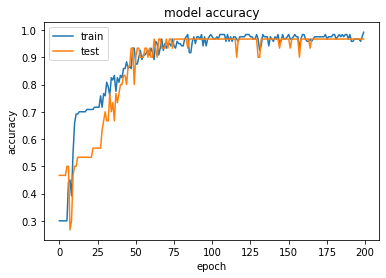

In [13]:
train_history.history['accuracy']
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

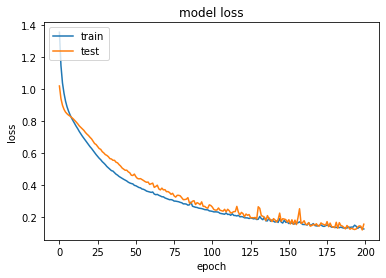

In [14]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
predictions = model.predict(test_feature_array)

In [16]:
tf.nn.softmax(predictions)
# predict class 
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(test_label_array))

Prediction: [1 2 0 1 1 1 0 2 1 2 2 0 2 1 1 0 1 0 0 2 0 1 2 2 1 1 0 1 2 1]
    Labels: [1 2 0 1 1 1 0 2 1 2 2 0 2 1 1 0 1 0 0 2 0 1 2 1 1 1 0 1 2 1]


### DEFINE ERROR MODEL

In [33]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  error_inject_layer.DenseErrorLayer(5, activation=tf.nn.relu,
                                        error_rate=0.1, 
                                        error_type='random_bit_flip_percentage',
                                        error_inject_phase='training',
                                        error_element='weight',
                                        ),  # input shape required
  tf.keras.layers.Dense(3)
])

In [34]:
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [35]:
num_epochs = 200

train_history2 = model2.fit(x=train_feature_array, y=train_label_array, 
                           validation_data=(test_feature_array, test_label_array),
                           batch_size=32, epochs=num_epochs,
                           shuffle=True,
                           verbose=0
                           )

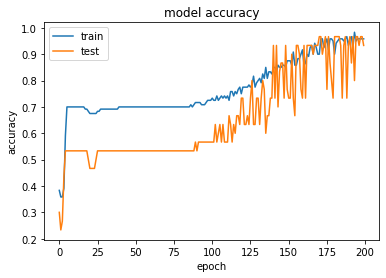

In [36]:
plt.plot(train_history2.history['accuracy'])
plt.plot(train_history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

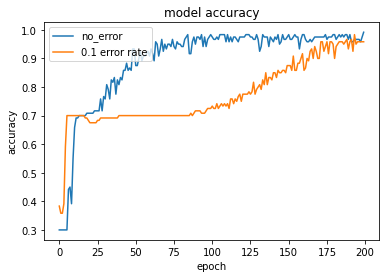

In [37]:

plt.plot(train_history.history['accuracy'])
plt.plot(train_history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['no_error', '0.1 error rate'], loc='upper left')
plt.show()

### Testing convergence of simple NN (Error in middle layer) with different error rates

In [27]:
error_rates = [0.0001, 0.001, 0.01,
               0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
               0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

error_rate_train_history = []

In [42]:


for error_rate in error_rates:
    test_model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
        tf.keras.layers.Dense(10, activation=tf.nn.relu),
        error_inject_layer.DenseErrorLayer(5, activation=tf.nn.relu,
                                            error_rate=0.1, 
                                            error_type='random_bit_flip_percentage',
                                            error_inject_phase='training',
                                            error_element='weight',
                                            ),  # input shape required
        tf.keras.layers.Dense(3)
    ])
    
    test_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])
    
    num_epochs = 200

    train_history_tmp = test_model.fit(x=train_feature_array, y=train_label_array, 
                           validation_data=(test_feature_array, test_label_array),
                           batch_size=32, epochs=num_epochs,
                           shuffle=True,
                           verbose=0
                         )
    
    error_rate_train_history.append((error_rate, train_history_tmp))
    

TRAINING
KERNEL SHAPE
(10, 5)
[ 0.15125841 -0.51661676 -0.36513215 -0.24024796  0.4507944  -0.5382883
 -0.20108292  0.61884576 -0.4295897   0.09653252  0.04472196 -0.35694656
  0.04688096  0.60530657  0.06727672  0.14628643  0.26291096 -0.60532266
 -0.09315813 -0.33437207  0.34599125  0.3281083   0.2621982   0.5071953
 -0.05681539 -0.23877779  0.21927667 -0.3547764  -0.466967   -0.5465737
  0.16257346 -0.51488113  0.11780041 -0.44082153 -0.5491837  -0.06164801
 -0.55302465 -0.3160981   0.48089522  0.19971281 -0.57106745  0.4331755
  0.56280357 -0.462307   -0.03077167 -0.5914177   0.20793796 -0.36841574
 -0.38865978 -0.31992948]
WEIGHT:  -0.093158126
ADJUSTED:  -0.023289531469345093
WEIGHT:  -0.3160981
ADJUSTED:  -0.3160942792892456
WEIGHT:  0.04688096
ADJUSTED:  0.04691147804260254
WEIGHT:  -0.24024796
ADJUSTED:  -0.2089979648590088
WEIGHT:  0.19971281
ADJUSTED:  0.1958065629005432
POST INJECT
[[ 0.15125841 -0.51661676 -0.36513215 -0.20899796  0.4507944 ]
 [-0.5382883  -0.20108292  0.6

In [43]:
error_rate_train_history

[(0.0001, <tensorflow.python.keras.callbacks.History at 0x7fe5d05a80d0>),
 (0.001, <tensorflow.python.keras.callbacks.History at 0x7fe5d044cf70>),
 (0.01, <tensorflow.python.keras.callbacks.History at 0x7fe5d030a160>),
 (0.1, <tensorflow.python.keras.callbacks.History at 0x7fe5d02147f0>),
 (0.15, <tensorflow.python.keras.callbacks.History at 0x7fe5d0130d30>),
 (0.2, <tensorflow.python.keras.callbacks.History at 0x7fe61c1ad580>),
 (0.25, <tensorflow.python.keras.callbacks.History at 0x7fe61c384970>),
 (0.3, <tensorflow.python.keras.callbacks.History at 0x7fe61c237c70>),
 (0.35, <tensorflow.python.keras.callbacks.History at 0x7fe5d0211d90>),
 (0.4, <tensorflow.python.keras.callbacks.History at 0x7fe61c1a0d60>),
 (0.45, <tensorflow.python.keras.callbacks.History at 0x7fe5c87e95e0>),
 (0.5, <tensorflow.python.keras.callbacks.History at 0x7fe5c86f69a0>),
 (0.55, <tensorflow.python.keras.callbacks.History at 0x7fe5c85f9190>),
 (0.6, <tensorflow.python.keras.callbacks.History at 0x7fe5c849d49

In [48]:
error_rate_train_history[5][1].history['accuracy']

[0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3499999940395355,
 0.3583333194255829,
 0.3583333194255829,
 0.3583333194255829,
 0.36666667461395264,
 0.36666667461395264,
 0.36666667461395264,
 0.4000000059604645,
 0.4416666626930237,
 0.46666666865348816,
 0.550000

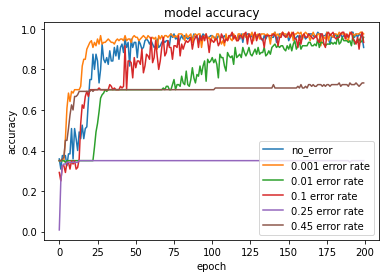

In [56]:
plt.plot(train_history.history['accuracy'])
# plt.plot(error_rate_train_history[0][1].history['accuracy'])
plt.plot(error_rate_train_history[1][1].history['accuracy'])
plt.plot(error_rate_train_history[2][1].history['accuracy'])
plt.plot(error_rate_train_history[3][1].history['accuracy'])
plt.plot(error_rate_train_history[6][1].history['accuracy'])
plt.plot(error_rate_train_history[10][1].history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['no_error', 
#             f'{error_rate_train_history[0][0]} error rate',
            f'{error_rate_train_history[1][0]} error rate',
            f'{error_rate_train_history[2][0]} error rate',
            f'{error_rate_train_history[3][0]} error rate',
            f'{error_rate_train_history[6][0]} error rate',
            f'{error_rate_train_history[10][0]} error rate'])
plt.show()

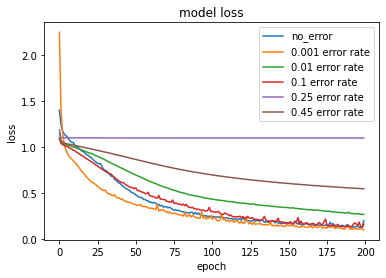

In [57]:
plt.plot(train_history.history['loss'])
# plt.plot(error_rate_train_history[0][1].history['accuracy'])
plt.plot(error_rate_train_history[1][1].history['loss'])
plt.plot(error_rate_train_history[2][1].history['loss'])
plt.plot(error_rate_train_history[3][1].history['loss'])
plt.plot(error_rate_train_history[6][1].history['loss'])
plt.plot(error_rate_train_history[10][1].history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['no_error', 
#             f'{error_rate_train_history[0][0]} error rate',
            f'{error_rate_train_history[1][0]} error rate',
            f'{error_rate_train_history[2][0]} error rate',
            f'{error_rate_train_history[3][0]} error rate',
            f'{error_rate_train_history[6][0]} error rate',
            f'{error_rate_train_history[10][0]} error rate'])
plt.show()